In [1]:
import os
import os.path

from urllib.parse import urlparse
from urllib.parse import parse_qs
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import linregress

import boto3
import numpy as np
import pandas as pd

# Data Challenge

Files are stored in an S3 bucket. The purpose here is to fully analyze the data and make some predictions.

This workbook was exported to a Python script and the resulting code was checked for PEP8 problems. The problems found were with formatting and order of imports. We can't fix the latter due to the way the script is exported from the notebook.

Any known or potential performance problems are flagged for further work.

Some of the information here is based on posts from Stackoverflow. I haven't kept up with it, so I'll just indicate by flagging with **SO**.

## Prepare an AWS Instance

We're using a **tiny** instance here since the data and processing requirements are minimal.

1. Install Anaconda for Python 3.6.
2. Install the ```boto3``` and ```seaborn``` packages.
3. Install and configure the AWS command-line tools.
4. Use ```jupyter notebook --generate-config``` to generate a config file in ```~/.jupyter```. An example is enclosed in the GitHub repository.
5. Run ```conda install -c conda-forge jupyter_contrib_nbextensions```.
6. [Configure Jupyter](http://jupyter-notebook.readthedocs.io/en/stable/public_server.html) on the remote side to run without a browser and to require a password. Make sure you put the config file in the proper place.
7. On the client side, run ```ssh -N -L 8888:localhost:8888 ubuntu@ec2-34-230-78-129.compute-1.amazonaws.com``` (the hostname may vary). This sets up the ssh tunnel and maps to port 8888 locally.
8. ssh into the instance using ```ssh ubuntu@ec2-34-230-78-129.compute-1.amazonaws.com```.
9. Start ```jupyter notebook```.

Note: You can start the ```tmux``` terminal multiplexer in order to use notebooks when you are logged out.

Note: This doesn't start X windows tunnelling, which is a separate configuration and is not presented here.

## Get the Data from S3

Instead of processing the data with the ```boto3.s3``` class, we chose to

```bash
aws s3 cp --recursive s3://my_bucket_name local_folder
```

This is not scalable, so we can use code such as

```python
s3 = boto3.resource('s3')
bucket_name = "postie-testing-assets"
test = s3.Bucket(bucket_name)
s3.meta.client.head_bucket(Bucket=bucket_name)
# {'ResponseMetadata': {'HTTPHeaders': {'content-type': 'application/xml',
#  'date': 'Mon, 16 Oct 2017 18:06:53 GMT',
#  'server': 'AmazonS3',
#  'transfer-encoding': 'chunked',
#  'x-amz-bucket-region': 'us-east-1',
#  'x-amz-id-2': 'YhUEo61GDGSwz1qOpFGJl+C9Sxal34XKRYzOI0TF49PsSSGsbGg2Y6xwbf07z+KHIKusPIYkjxE=',
#  'x-amz-request-id': 'DDD0C4B61BDF320E'},
# 'HTTPStatusCode': 200,
# 'HostId': 'YhUEo61GDGSwz1qOpFGJl+C9Sxal34XKRYzOI0TF49PsSSGsbGg2Y6xwbf07z+KHIKusPIYkjxE=',
# 'RequestId': 'DDD0C4B61BDF320E',
# 'RetryAttempts': 0}}
for key in test.objects.all():
    print(key.key)
# 2017-07-01.csv
# 2017-07-02.csv
# 2017-07-03.csv
```

We did not bother to use ```boto3```.

## Import and Process the Data

The most difficult part was processing the url query string. We are using ```convert_list``` as a helper funtion during import. It allows us to parse the url query string out properly into a Pandas ```Series``` whose elements are dictionaries. We're rewriting the dictonyary before returning it to transform everything to ```int```. **Note that we are handling the ```error``` key in the url. There is only one of these, but it looks like a completed transaction. We don't know why it's there, so we will keep it until we learn more.**

Also, once we have a ```pd.Series``` object, we can apply the ```Series``` constructor to map the key-value pairs from the parsed query string into a separate DataFrame. This frame has the same number of rows, and is in the same order, as the original data. So we can just use the ```join``` method to put together the two DataFrames.

We then make a large DataFrame to keep all the data, and keep a list of DataFrame around for each file imported (just in case).

## Prediction

To build a predictive model, we need more data. Ideally, we should enrich with customer and item information. An interesting idea is to use the item images from the website to generate features.

## Data Issues

1. Column names have spaces, so we need to remove them. A more sophisticated method would do this on import. However, processing the first row in this way may slow down the import process, particularly if the files are much larger. There are ways to read chunks via ```read_csv```, which can be used in a class to get the first line of the file, process it as a header, then continue reading the rest of the file in chunks. This is probably the best way to read many large files.
2. Placeholder is blank (NaN) for two files. But is this needed?
3. The file labeled "2017-07-01" has transactions for 7/1/2017 and 7/2/2017.
4. The file labeled "2017-07-02" has transactions for 7/2/2017 and 7/3/2017.
5. The file labeled "2017-07-03" has transactions only for 7/3/2017.
6. There are two website id's, but one website id has two separate domain names: store.example.com, and www.example.com. This affects counts and also reporting if using the domain name. **Handling the domain names is very dependent on this dataset - no effort was made to write a more general solution**.
7. Some of the checkout values are negative. Do the websites allow online returns? What does a negative checkout amount mean? We will assume that negative values are recorded with the wrong sign. So we take the absolute value of the ```checkout_amount```.

In [2]:
def convert_list(query_string):
    """Parse the query string of the url into a dictionary.
    
    Handle special cases:
    - There is a single query "error=True" which is rewritten to 1 if True, else 0.
    - Parsing the query returns a dictionary of key-value pairs. The value is a list.
      We must get the list value as an int.
      
    Note: This function may be a bottleneck when processing larger data files.
    """
    def handle_error(z, col):
        """
        Called in the dictionary comprehension below to handle the "error" key.
        """
        if "error" in col:
            return 1 if "True" in z else 0
        return z
    dd = parse_qs(query_string)
    return {k: int(handle_error(dd[k][0], k)) for k in dd}

## Explanation of Import Code

- We are using ```dfr``` instead of ```fr```. The latter is the name of a function in ```R```.
- We want to use the Pandas csv import and parse the timestamp into a ```Timestamp``` field.
- The code assumes there are only csv files to process in the ```data``` directory. This can be fixed but it makes the code more complicated and will not be addressed here.
- See above for a few issues discovered with the data.
- We parse the url field to obtain the item counts purchased. This allows us to infer prices.
- ```urlparse``` returns a structure. The first element is the hostname, and the fourth is the query string (if available). All our url strings have a query string, so we don't need any special processing here.
- Apply the function ```convert_list``` to the query ```Series```. The result is a ```Series```. Why is this important?

```python
    qq = item_query.apply(lambda x: convert_list(x)).apply(pd.Series).fillna(value=0)
```

- We need to apply the ```Series``` constructor to each row of the results of ```convert_list```. The constructor parses the key-value pairs into columns and creates a DataFrame. We then fill the ```NaN``` values introduced. Since the resulting DataFrame has the same rows, in the same order, as the source frame (```ffr```, see below), we can just use the ```join``` method.
- We keep a list DataFrames of the separate files.

In [3]:
dfr = pd.DataFrame()
col_names = ["timestamp", "website_id", "customer_id", "app_version", "placeholder", "checkout_amount", "url"]
data_report = []
individual_days = []
item_lists = []
for fname in os.listdir("data"):
    ffr = pd.read_csv(os.path.join("data", fname),
                      header=0, names=col_names,
                      infer_datetime_format=True, parse_dates=[0])
    file_date = fname.split(".")[0]
    ffr["file_date"] = file_date
    transaction_date = ffr.timestamp.apply(lambda x: x.strftime('%Y-%m-%d'))  # reformat transaction timestamp
    ffr["transaction_date"] = transaction_date
    url_items = ffr.url.apply(lambda x: urlparse(x))
    domain_name = url_items.apply(lambda x: x[1])
    # handle store.example.com and www.example.com as the same website
    ffr["domain_name"] = domain_name.apply(lambda x: x if not "example.com" in x else ".".join(x.split(".")[1:]))
    item_query = url_items.apply(lambda x: x[4])
    qq = item_query.apply(lambda x: convert_list(x)).apply(pd.Series).fillna(value=0)
    item_lists += qq.columns.tolist()
    final_fr = ffr.join(qq)
    print("date {} has {} sales for rows {} and unique dates {}".format(fname, ffr.checkout_amount.sum(),
                                                                        ffr.shape[0],
                                                                        transaction_date.unique().shape[0]))
    data_report.append({"file_date": file_date, "sales": ffr.checkout_amount.sum(),
                        "n_placeholder_nan": sum(ffr.placeholder.isnull()),
                        "n_rows": ffr.shape[0],
                        "n_websites": ffr.website_id.unique().shape[0],
                        "n_customers": ffr.customer_id.unique().shape[0],
                        "n_app_versions": ffr.app_version.unique().shape[0],
                        "n_dates": transaction_date.unique().shape[0]})
    dfr = dfr.append(final_fr)
    individual_days.append(final_fr)
### Note: This is an assumption
dfr["checkout_amount"] = dfr["checkout_amount"].abs()
dfr.reset_index(drop=True, inplace=True)
item_lists = list(set([item for item in item_lists if not "error" in item]))
dfr.shape

date 2017-07-02.csv has 183294.0 sales for rows 11573 and unique dates 2
date 2017-07-01.csv has 241491.0 sales for rows 11634 and unique dates 2
date 2017-07-03.csv has 164065.0 sales for rows 9981 and unique dates 1


(33188, 21)

Just to make sure there are no inconsistencies in the data, let's check the ```website_id``` against the domain name we've extracted.

In [4]:
pd.pivot_table(dfr, values="website_id", index="transaction_date", columns="domain_name", aggfunc=[np.max])

amax        
domain_name      example.com xyz.com
transaction_date                    
2017-07-01               123     124
2017-07-02               123     124
2017-07-03               123     124

Finally, let's drop the ```error``` column. It affects a single row, and we don't have enough information to determine if this is a legitimate error or not.

In [5]:
dfr.drop(["error"], axis=1, inplace=True)

## Potential Performance Issues

- Import code processing by file: handle url and domain name processing outside the loop.
- Wrap import code into a function and read in the data using a list comprehension.
- Keeping a list of DataFrames for each file imported is not necessary and should be eliminated in pipeline code.
- Extract the individual item price by domain name upon import.

## Summaries of the Data

First, let's check out the total sales per ```transaction_date```. This is the date from the ```timestamp``` field.  A separate field ```file_date``` will also be used to reveal problems with the data.

Note: These pivot tables can obviously be reformatted but we will not bother here. That's something to do when presenting externally.

In [6]:
pd.pivot_table(dfr, values="checkout_amount", index="transaction_date", columns="domain_name",
               aggfunc=[np.sum], margins=True)

sum                    
domain_name      example.com   xyz.com       All
transaction_date                                
2017-07-01          172874.0   50641.0  223515.0
2017-07-02          127786.0   55966.0  183752.0
2017-07-03           64743.0  117248.0  181991.0
All                 365403.0  223855.0  589258.0

Before we comment further, here are total sales per ```file_date```. This is the date we got from the file name, *assuming that each file contains a single day of data*.

In [7]:
pd.pivot_table(dfr, values="checkout_amount", index="file_date", columns="domain_name",
               aggfunc=[np.sum], margins=True)

sum                    
domain_name example.com   xyz.com       All
file_date                                  
2017-07-01     182100.0   59391.0  241491.0
2017-07-02     127466.0   55828.0  183294.0
2017-07-03      55837.0  108636.0  164473.0
All            365403.0  223855.0  589258.0

So now we can see what's happening. Since the files do not separate dates properly, the average sales are off. We need to use the actual transaction date to calculate sales. Additionally, some of the checkout values are negative. This distorts the sales.

The analyst's question is thus answered - there is a problem with just importing one file to calculate the average sales. Also, average sales, while meaningful, is not a good metric. It is sensitive to outliers, so a very large or small transaction has a large effect on the average. A better measure would be the median or quartiles. But let's look at a boxplot of the data first.

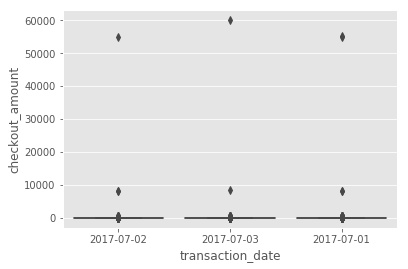

In [8]:
sns.boxplot(x="transaction_date", y="checkout_amount", data=dfr);

This is a [boxplot](http://seaborn.pydata.org/generated/seaborn.boxplot.html), which is a good way to display outliers, the median, quartiles, and range. We can see immediately that we have a problem with the wide range of checkout amounts. This is why the interquartile range is so compressed. There are two options.

- The large values are not legitimate transactions. In this case, they are true outliers and should be ignored.
- The large values are definitely legitimate transactions. This will complicate any predictive model.

We need more information about sales. We need to know if the negative values are recorded wrong.

## Extracting Prices from the URL

Let's now use the pricing information extracted from the url. We can query items in the DataFrame to find this information. At this point, we assume that prices are not changed on items during the day. This *seems* to be the case with this data, but we can't make that assumption about future data.

Note: We are doing the item prices separately since the method used to produce the DataFrame above isn't adaptable. A different method of processing the data which avoids using the convienence of the ```pd.Series``` constructor can be used, at the expense of more difficult processing of the parsed url. Also, it's possible that an item only appears for a given domain name on a particular day, meaning we must process all the data first.

First, to get the rows where only one item was purchased, we can use (**SO**)

```python
dfr[dfr[cols].astype(bool).sum(axis=1) == 1]
```

We then calculate the pricing and reformulate the data into a table we can view. This code is annoying to write, so it's preferable to redo the above loop to get the pricing. However, that may slow down processing.

In [9]:
cols = [item for item in item_lists if not "error" in item]
pricing_temp = dfr[dfr[cols].astype(bool).sum(axis=1) == 1].copy()  # to avoid setting values on a view
pricing_temp.drop_duplicates(subset=cols + ["domain_name", "transaction_date"], inplace=True)
price_cols = []
for col in cols:
    price_cols.append(np.abs(pricing_temp["checkout_amount"]/pricing_temp[col]))
pricing = pd.concat(price_cols, axis=1)
pricing.columns = cols
price_cols = [col + "_price" for col in cols]
px = pricing_temp.join(pricing, rsuffix="_price")[price_cols + ["transaction_date", "domain_name"]]
px = px.replace([np.inf, -np.inf], np.nan).fillna(value=0)
pd.pivot_table(px, values=price_cols, index="transaction_date", columns="domain_name", aggfunc=np.max).transpose()

transaction_date                      2017-07-01  2017-07-02  2017-07-03
                         domain_name                                    
Bignay_price             example.com         6.0         6.0         6.0
                         xyz.com             6.0         6.0         6.0
Black/White Pepper_price example.com         5.0         5.0         5.0
                         xyz.com             5.0         5.0         5.0
European Grape_price     example.com         5.0         5.0         5.0
                         xyz.com             5.0         5.0         5.0
Hazelnut_price           example.com         4.0         4.0         4.0
                         xyz.com             4.0         4.0         4.0
Mabolo_price             example.com         8.0         8.0         8.0
                         xyz.com             8.0         8.0         8.0
Natal Orange_price       example.com         6.0         6.0         6.0
                         xyz.com             6.0         6.0         6.0
Prairie Potato_price     example.com         3.0         3.0         3.0
                         xyz.com             3.0         3.0         3.0
Round Kumquat_price      example.com         7.0         7.0         7.0
                         xyz.com             7.0         7.0         7.0
Ume_price                example.com         6.0         6.0         6.0
                         xyz.com             6.0         6.0         6.0
Ylang-ylang_price        example.com         5.0         5.0         5.0
                         xyz.com             5.0         5.0         5.0

Based on this table, it seems true that prices do not change from day to day, or during the day. **However, what if a price was changed during the day, and then changed back? Our analysis will not pick this up**.

## Notes for the Analyst

- Make sure you understand what is in the files before you run an analysis.
- Research with the customer the negative checkout amounts.
- There is a single transaction with an error in the url query, but there is a seemingly valid item. Ask about this.
- What does placeholder mean? Why is it blank in two files?
- One of the websites has checkouts from two different subdomains. Make sure you understand this. Is one set of checkout amounts mobile versus desktop?
- The code I have produced is inefficient in many aspects. If you can modify the code to make it more efficient, do so. Otherwise, get back to me.
- Note that I can confirm your sales figure on the 3rd if I don't take the absolute value. The above analysis is **with** the absolute value of the checkout amount.
- Are the checkout amounts consistent with the prices we calculated? Check this.
- Check the data issues above to find anything I missed.

## Analysis of Purchases

This is not hard, but the format of the results is a bit difficult to see. Let's reduce our dataset down a bit to examine counts of purchases.

In [10]:
frame = dfr[item_lists + ["transaction_date", "domain_name", "checkout_amount"]]
gr = frame.groupby(["transaction_date", "domain_name"])

Now we can look at the top five purchases. Let's concentrate first on **Bignay**.

At the risk of overcomplicating the code, let's make a data structure which may not be optimal. We shall see.

In [11]:
gb_frames = []
for name, group in gr:
    gb_frames.append({"date": name[0], "domain_name": name[1], "frame": group})

In [12]:
gb_frames[0]["frame"].nlargest(5, "Bignay")

,Hazelnut,Black/White Pepper,Prairie Potato,Mabolo,Bignay,European Grape,Natal Orange,Ume,Round Kumquat,Ylang-ylang,transaction_date,domain_name,checkout_amount
15209,1015.0,1049.0,983.0,1059.0,999.0,1011.0,965.0,998.0,963.0,958.0,2017-07-01,example.com,55084.0
14280,995.0,1005.0,1013.0,1020.0,990.0,976.0,999.0,981.0,1011.0,1010.0,2017-07-01,example.com,55031.0
19493,159.0,170.0,143.0,130.0,163.0,160.0,166.0,151.0,147.0,111.0,2017-07-01,example.com,8219.0
15066,174.0,140.0,142.0,146.0,140.0,138.0,155.0,180.0,135.0,150.0,2017-07-01,example.com,8225.0
17421,11.0,14.0,7.0,6.0,16.0,7.0,7.0,15.0,8.0,9.0,2017-07-01,example.com,547.0


We can see that a lot of items are bought from ```example.com``` in bulk, and together. This means shipping costs for these orders are higher.

In [13]:
gb_frames[1]["frame"].nlargest(5, "Bignay")

,Hazelnut,Black/White Pepper,Prairie Potato,Mabolo,Bignay,European Grape,Natal Orange,Ume,Round Kumquat,Ylang-ylang,transaction_date,domain_name,checkout_amount
17016,15.0,12.0,7.0,6.0,13.0,6.0,10.0,15.0,8.0,8.0,2017-07-01,xyz.com,543.0
11652,9.0,12.0,14.0,6.0,11.0,10.0,8.0,8.0,13.0,9.0,2017-07-01,xyz.com,534.0
13345,8.0,8.0,12.0,7.0,11.0,5.0,14.0,14.0,10.0,11.0,2017-07-01,xyz.com,548.0
13523,7.0,12.0,12.0,11.0,11.0,14.0,5.0,10.0,7.0,11.0,2017-07-01,xyz.com,542.0
16880,8.0,10.0,11.0,12.0,11.0,8.0,6.0,12.0,10.0,12.0,2017-07-01,xyz.com,555.0


And for ```xyz.com```, we see a different pattern. the checkout amounts are lower, and the number of items bought together is much lower. So shipping costs are lower.

We can get the data for 7/2/2017 using ```gb_frames[2]```, etc, and for 7/3/2017 using ```gb_frames[4]```, etc. They will not be displayed here.

It's a bit difficult to generalize this to other columns without further analysis, and it's tedious to do ```nlargest``` for each column. Let's look at the correlation between order amounts for each website. First, an example. Then we will look at each date individually.

Note: **The checkout amount is collinear with the item counts.**

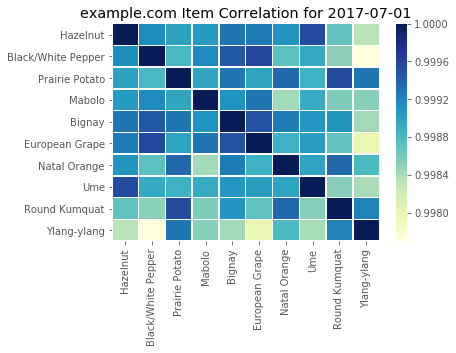

In [14]:
corr = gb_frames[0]["frame"][item_lists].corr()
ax = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,
                 linewidths=.5, cmap="YlGnBu")
plt.title("{} Item Correlation for {}".format(gb_frames[0]["domain_name"], gb_frames[0]["date"]));

This type of plot gives us information about which items are bought together. Let's see one for ```xyz.com```.

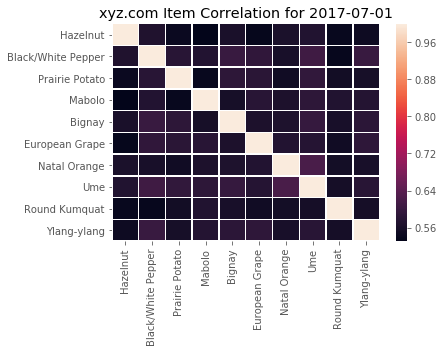

In [15]:
corr = gb_frames[1]["frame"][item_lists].corr()
ax = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,
                 linewidths=.5)  #, cmap="YlGnBu")
plt.title("{} Item Correlation for {}".format(gb_frames[1]["domain_name"], gb_frames[1]["date"]));

It's very interesting to see that the item correlations are much lower. Originally, we used the same colormap as for the first heatmap, but the lower correlations didn't look as well (the colors wash out). It's difficult to distinguish the colors here. More research is needed to produce meaningful colors in these plots.
 
At this point, we could write a few loops and use subplots to display more information.

## Sales Prediction

Let's take a look at the daily sales again.

In [16]:
pt = pd.pivot_table(dfr, values="checkout_amount", index="transaction_date", columns="domain_name",
                    aggfunc=[np.sum], margins=False)
pt.columns = ["example.com", "xyz.com"]  # get rid of multiindex
pt

,example.com,xyz.com
transaction_date,,
2017-07-01,172874.0,50641.0
2017-07-02,127786.0,55966.0
2017-07-03,64743.0,117248.0


Here are a few modeling considerations.

- We only have three days to work with. That's not enough.
- There are questions to clear up about the data.
- How does the app version and placeholder affect the data?

However, we can make some predictions at this point. First, we can make the following prediction by averaging.

In [17]:
for col in pt.columns.tolist():
    print("Tomorrow's (7/14/2017) sales for {} is {}".format(col, pt[col].mean()))

Tomorrow's (7/14/2017) sales for example.com is 121801.0
Tomorrow's (7/14/2017) sales for xyz.com is 74618.33333333333


We can also draw a regression plot and make predictions using the regression line.

First, there are a few details with the index. Placing the labels is also annoying. The alternatives are to use the Pandas plotting capabilities. In fact, there is no really good solution to plotting a time series and associated regression line without creating the regression line values in the DataFrame. This latter idea is what I usually do, however, the below charts were produced in a different way.

Note that both show a clear linear trend. However, there are problems - we just don't have enough data. ```regplot``` is a good tool for linear regression plots, but it does have its deficiencies, such as not providing the slope and intercept of the regression line. Additionally, the error region is not meaningful with this small amount of data.

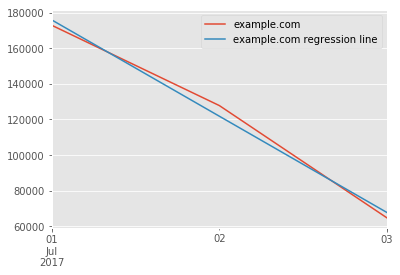

In [18]:
pt = pd.pivot_table(dfr, values="checkout_amount", index="transaction_date", columns="domain_name",
               aggfunc=[np.sum], margins=False)
pt.columns = ['example.com', 'xyz.com']
pt.index = pd.DatetimeIndex(pt.index)
idx = pd.date_range(pt.index.min(), pt.index.max())
pt = pt.reindex(index=idx)
pt.insert(pt.shape[1],
          'row_count',
          pt.index.value_counts().sort_index().cumsum())
slope, intercept, r_value, p_value, std_err = linregress(x=pt["row_count"].values,
                                                         y=pt["example.com"].values)
pt["example.com regression line"] = intercept + slope * pt["row_count"]
ax = pt[["example.com", "example.com regression line"]].plot()

And the sales prediction is

In [19]:
print("Predicted sales for example.com on 7/4/2014 is {} with significance {}".format(intercept + slope * 4, r_value*r_value))

Predicted sales for example.com on 7/4/2014 is 13670.0 with significance 0.9908929885865992


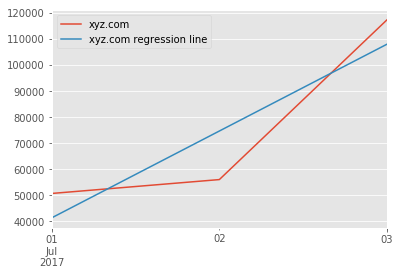

In [20]:
pt = pd.pivot_table(dfr, values="checkout_amount", index="transaction_date", columns="domain_name",
                    aggfunc=[np.sum], margins=False)
pt.columns = ["example.com", "xyz.com"]
pt.index = pd.DatetimeIndex(pt.index)
idx = pd.date_range(pt.index.min(), pt.index.max())
pt = pt.reindex(index=idx)
pt.insert(pt.shape[1],
          'row_count',
          pt.index.value_counts().sort_index().cumsum())
slope, intercept, r_value, p_value, std_err = linregress(x=pt["row_count"].values,
                                                         y=pt["xyz.com"].values)
pt["xyz.com regression line"] = intercept + slope * pt["row_count"]
ax = pt[["xyz.com", "xyz.com regression line"]].plot()

Again, the sales prediction is

In [21]:
print("Predicted sales for xyz.com on 7/4/2014 is {} with significance {}".format(intercept + slope * 4, r_value*r_value))

Predicted sales for xyz.com on 7/4/2014 is 141225.3333333333 with significance 0.8095462566399501


To build a predictive model, we need more data. Ideally, we should enrich with customer and item information. An interesting idea is to use the item images from the website to generate features.